In [1]:
# Cone-beam tomographic reconstruction: Chambolle-Pock algorithm using ODL core

In [2]:
import ctdata
from pyastra import Geometry
from odl import Rn
from algorithm import ODLChambollePock
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from utils import show_slices, slicing
import time

%matplotlib inline
figsize=(10, 4)

## CT data set
GATE simulated data

Data set: 20150616_CT_for_SPECT_attenuation


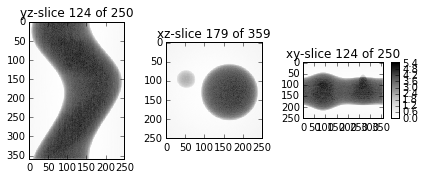

In [3]:
d = ctdata.sets[14]
d.load()
print 'Data set:', d.filename
fig = show_slices(d.projections)

## Geometry instance

In [4]:
det_row_count, num_proj, det_col_count = d.shape
voxel_size = 2 * d.roi_cubic_width_mm / det_col_count
geom = Geometry(
    volume_shape=(det_col_count, det_col_count, det_row_count),
    det_row_count=det_row_count,
    det_col_count=det_col_count,
    angles=d.angles_rad,
    source_origin=d.distance_source_origin_mm / voxel_size,
    origin_detector=d.distance_origin_detector_mm / voxel_size,
    det_col_spacing=d.detector_width_mm / det_col_count / voxel_size,
    det_row_spacing=d.detector_width_mm / det_row_count / voxel_size,
    voxel_size=1
    )

In [5]:
print 'distance source detector:', d.distance_source_detector_mm
print 'distance source origin:', d.distance_source_origin_mm
print 'detector width:', d.detector_width_mm
det_width_proj = d.detector_width_mm * d.distance_source_origin_mm / d.distance_source_detector_mm
print 'detector width projected to origin:', det_width_proj
print 'cubic ROI:', d.roi_cubic_width_mm

distance source detector: 1085.6
distance source origin: 595.0
detector width: 950.0
detector width projected to origin: 520.679808401
cubic ROI: 331.062587568


## Rn vector of projections

In [6]:
proj_vec = Rn(geom.proj_size).element(d.projections.ravel())

## Initialize algorithm

In [7]:
cp = ODLChambollePock(geom, proj_vec)

### Compute matrix norm of projector

In [ ]:
norm_iter = 50
matrix_norm = cp.matrix_norm(
    iterations=norm_iter,
    intermediate_results=True,
    tv_norm=False)
matrix_norm_tv = cp.matrix_norm(
    iterations=norm_iter,
    intermediate_results=True,
    tv_norm=True)

Rescale backprojector by adjoint scaling factor

In [ ]:
cp.adjoint_scaling_factor()
s = cp.adj_scal_fac
matrix_norm_r = cp.matrix_norm(
    iterations=norm_iter,
    intermediate_results=True,
    tv_norm=False)
matrix_norm_tv_r = cp.matrix_norm(
    iterations=norm_iter,
    intermediate_results=True,
    tv_norm=True)

In [ ]:
print 'Operator norm using non-rescaled backprojector'
print ' Least squares:', matrix_norm[-1]
print ' Least squares + TV:', matrix_norm_tv[-1]
print 'Operator norm using backprojector rescaled by ', s
print ' Leas squares', matrix_norm_r[-1]
print ' Least squares + TV:', matrix_norm_tv_r[-1]

Above values before projector rescaling by number of projections:

Operator norm using unscaled backprojector
 Least squares: 270.618678007
 Least squares + TV: 270.618678367
Operator norm using backprojector rescaled by  1.95261139898
 Leas squares 270.618678008
 Least squares + TV: 270.618678608

#### Plots: operator norm vs iteration

In [ ]:
%matplotlib inline
# plt.switch_backend('qt4agg')
# print plt.get_backend()
fig = plt.figure('Matrix norm for non-rescaled backprojector', figsize=(10,3))
# Non-rescaled backprojector
# Projector
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Least squares: K_LS = A')
ax1.set_ylabel('matrix norm')
ax1.set_xlabel('iterations')
l1, = ax1.plot(matrix_norm)
# TV
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('TV: K_TV = (A, grad)')
ax2.set_ylabel('matrix norm')
ax2.set_xlabel('iterations')
l2, = ax2.plot(matrix_norm_tv)
# Difference
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('||K_TV|| - ||K_LS||')
ax3.set_ylabel('matrix norm difference')
ax3.set_xlabel('iterations')
ax3.yaxis.get_major_formatter().set_powerlimits((0, 1))
l3, = ax3.plot(matrix_norm_tv - matrix_norm)
plt.tight_layout()

In [ ]:
fig = plt.figure('Matrix norm for rescaled projector', figsize=(10,3))
# Rescaled backprojector
# Projector
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Least squares: K_LS = A')
ax1.set_ylabel('matrix norm ||K_LS||')
ax1.set_xlabel('iterations')
l1, = ax1.plot(matrix_norm_r)
# TV
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('TV: K_TV = (A, grad)')
ax2.set_ylabel('matrix norm ||K_TV||')
ax2.set_xlabel('iterations')
l2, = ax2.plot(matrix_norm_tv_r)
# Difference
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('||K_TV|| - ||K_LS||')
ax3.set_ylabel('matrix norm difference')
ax3.set_xlabel('iterations')
ax3.yaxis.get_major_formatter().set_powerlimits((0, 1))
l3, = ax3.plot(matrix_norm_tv_r - matrix_norm_r)
plt.tight_layout()

##### Difference between rescaled and unscaled operator norms for K_LS and K_TV

In [ ]:
fig = plt.figure('Difference of matrix norms between rescaled and unscaled back-projector', figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
# Least squares
ax1.set_title('Difference for K_LS = A')
ax1.set_ylabel('matrix norm difference')
ax1.set_xlabel('iterations')
l1, = ax1.plot(matrix_norm_r - matrix_norm)
# Least squares + TV
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Difference for K_TV = (A, grad)')
ax2.set_ylabel('matrix norm difference')
ax2.set_xlabel('iterations')
l2, = ax2.plot(matrix_norm_tv_r -  matrix_norm_tv)
plt.tight_layout()

## Unconstrained least-squares reconstruction
Display intermediate results use option verbose=True

In [ ]:
# switch backend to display intermediate results (verbosity=True)
plt.switch_backend('qt4agg')
(u, p, cpd, l2atp) = cp.least_squares(iterations=50, L=matrix_norm_r[-1],
     verbose=False, non_negativiy_constraint=False)

In [ ]:
proj_shape = cp.K.projection_shape
proj_size = cp.K.projection_data.size
vol_shape = cp.K.volume_shape
vol_size = cp.K.volume_data.size

### Convergence measures

In [ ]:
%matplotlib inline
fig = plt.figure('Convergence', figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('conditional prima-dual gap')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("l2-norm: A^T p'")
l1, = ax1.plot(cpd/vol_size)
l2, = ax2.plot(l2atp/proj_size)

### Ortho-slices of reconstructed volume

In [ ]:
fig_u = show_slices(u, fig_name='final reconstruction u', figsize=figsize)

### Ortho-slices of dual variable p

In [ ]:
fig_p = show_slices(p, fig_name='dual variable p', figsize=figsize)

In [ ]:
# Animtated slicing, probably crashing the notebook
# slicing(u)

In [ ]:
plt.switch_backend('qt4agg')
(un, pn, cpdn, l2atpn) = cp.least_squares(50, L=pn200,
     verbose=True, non_negativiy_constraint=True)

### Ortho-slices of reconstructed volume

In [ ]:
fig_u = show_slices(u, fig_name='final reconstruction u', figsize=figsize)

In [ ]:
plt.switch_backend('qt4agg')

fig = plt.figure('Animated slicing')

nn = 0
im = plt.imshow(d.projections[:, nn, :], cmap=plt.get_cmap('Greys'))

def updatefig(*args) :
    global nn
    nn += 1
    nn = np.mod(nn, d.shape[1])
    im = plt.imshow(d.projections[:, nn, :], cmap=plt.get_cmap('Greys'))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=10, blit=True)
# plt.show(block=False)
plt.show()